In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ------------------------------------------------------------------
# 1. Signal Specifications
# ------------------------------------------------------------------
fs = 100e6              # Sampling rate: 100 MHz
f1 = 12.5e6             # Sine wave 1: 12.5 MHz
f2 = 25e6             # Sine wave 2: 25 MHz
amp = 50               # Amplitude
fft_size = 256          # FFT points
num_packets = 1        # Number of packets to concatenate
total_samples = fft_size * num_packets

In [3]:
# ------------------------------------------------------------------
# 2. Generate Time Domain Signal
# ------------------------------------------------------------------
# Generate time vector for the total duration (10 packets)
t = np.arange(total_samples) / fs

# Create the signal: Sum of two sine waves
# x(t) = 0.5 * sin(2*pi*f1*t) + 0.5 * sin(2*pi*f2*t)
signal_real = amp * np.sin(2 * np.pi * f1 * t) + \
              amp * np.sin(2 * np.pi * f2 * t)
# signal_real = amp * np.sin(2 * np.pi * f1 * t)
# signal_real = amp * np.sin(2 * np.pi * f2 * t)

In [4]:
# ------------------------------------------------------------------
# 3. Apply Windowing
# ------------------------------------------------------------------
# The FFT block processes 256 samples at a time. 
# We must reshape the stream into blocks, apply the window, and flatten back.

# Reshape into (10, 256)
signal_blocked = signal_real.reshape((num_packets, fft_size))

# Create a Hanning window of length 256
window = np.hanning(fft_size)

# Apply window to each packet
# Broadcasting: (10, 256) * (256,) applies window to every row
windowed_blocked = signal_blocked * window

# Flatten back to a single stream of 2560 samples
signal_windowed_flat = windowed_blocked.flatten()

In [5]:
import time
# ------------------------------------------------------------------
# 4. Perform FFT (Python Reference) & Measure Time
# ------------------------------------------------------------------
print("Starting Python FFT...")
start_time = time.time()

# Run FFT on the blocked data (axis=1 performs FFT on each row independently)
fft_output_python = np.fft.fft(windowed_blocked, axis=1)

end_time = time.time()
execution_time_ms = (end_time - start_time) * 1000

print(f"Python FFT execution time (for {num_packets} packets): {execution_time_ms:.5f} ms")

Starting Python FFT...
Python FFT execution time (for 1 packets): 1.70827 ms


<IPython.core.display.Javascript object>


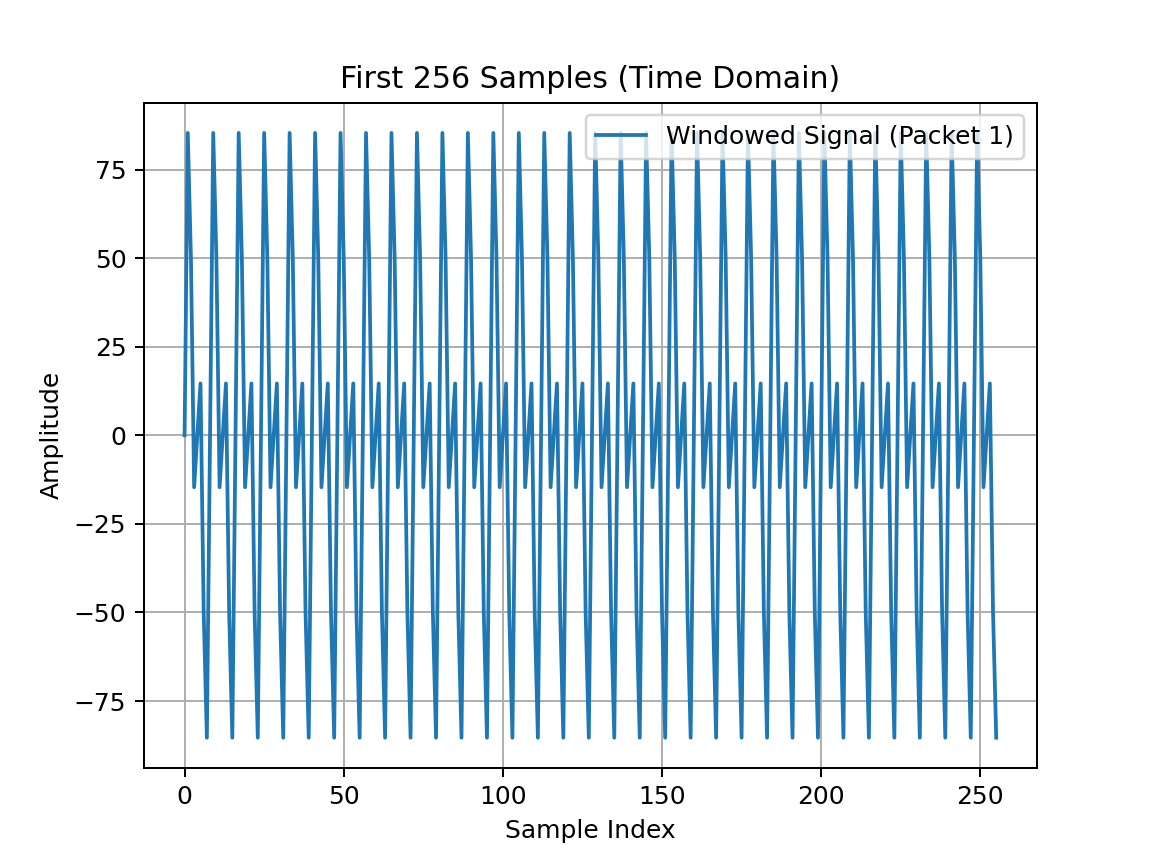

In [6]:
# Plot the first packet (256 samples) to verify windowing
plt.figure()
plt.plot(signal_real[0:256].real, label='Windowed Signal (Packet 1)')
plt.title("First 256 Samples (Time Domain)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


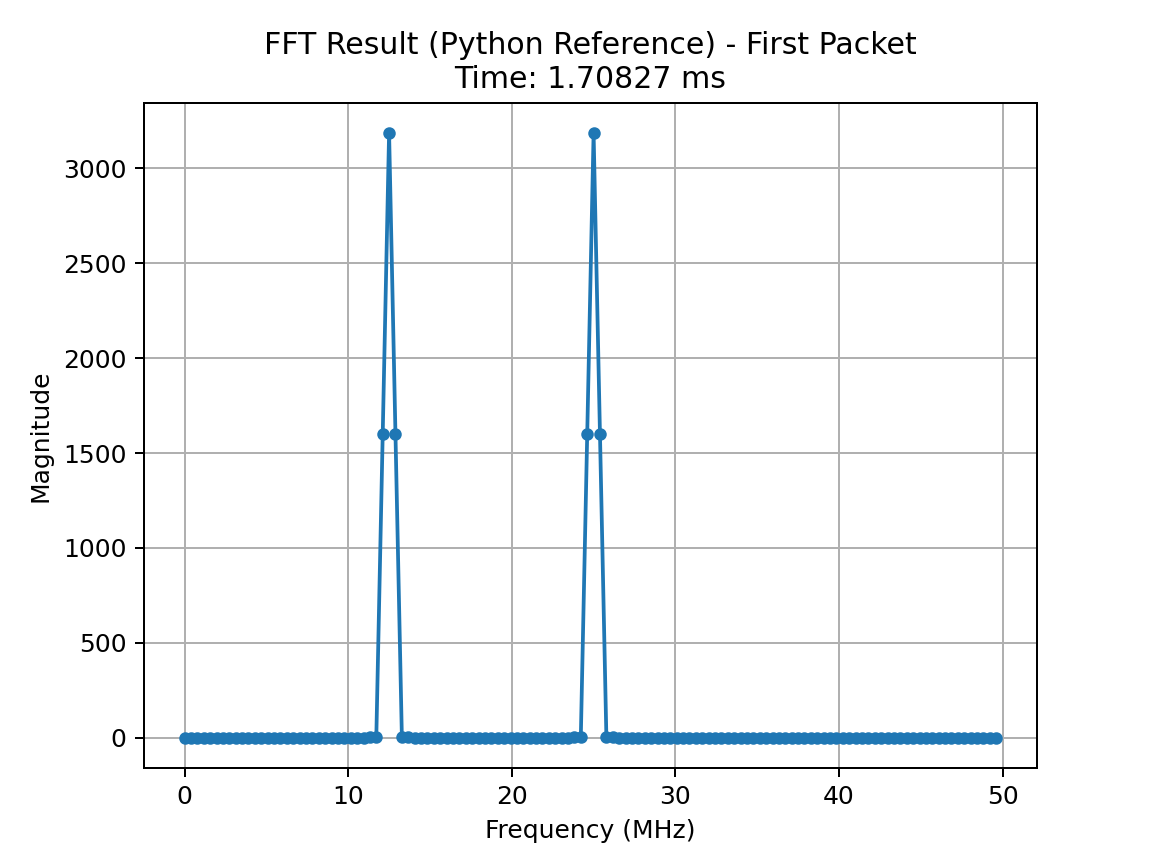

In [7]:
# ------------------------------------------------------------------
# 5. Visualization
# ------------------------------------------------------------------
# Calculate frequency axis
freqs = np.fft.fftfreq(fft_size, d=1/fs)
# Mask to keep only positive frequencies
mask = freqs >= 0
freqs_pos = freqs[mask] / 1e6  # Convert to MHz for plotting

# Get magnitude of the first packet for display
magnitude = np.abs(fft_output_python[0][mask])

plt.figure()
plt.plot(freqs_pos, magnitude, 'o-', markersize=4)
plt.title(f"FFT Result (Python Reference) - First Packet\nTime: {execution_time_ms:.5f} ms")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

In [8]:
from pynq import Overlay
from pynq import allocate

ol = Overlay("./overlays/fft.bit")

In [9]:
ol?

In [10]:
print(ol.ip_dict.keys())

dict_keys(['fft_top_0', 'axi_dma_0', 'processing_system7_0'])


In [11]:
fft_top = ol.fft_top_0
dma = ol.axi_dma_0

In [12]:
fft_top.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0)
}

In [13]:
dma.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=0, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=0),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=0),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SG

In [14]:
in_buffer = allocate(shape=(total_samples,), dtype=np.complex64)
out_buffer = allocate(shape=(total_samples,), dtype=np.complex64)

In [15]:
in_buffer[:] = signal_windowed_flat + 1j * 0.0

In [16]:
print(f"Buffer Allocated at Physical Address: {hex(in_buffer.device_address)}")
print(f"Total Samples: {len(in_buffer)}")
print(f"Data Type: {in_buffer.dtype}")
print(f"Buffer Allocated at Physical Address: {hex(out_buffer.device_address)}")
print(f"Data Type: {out_buffer.dtype}")

Buffer Allocated at Physical Address: 0x15849000
Total Samples: 256
Data Type: complex64
Buffer Allocated at Physical Address: 0x1584a000
Data Type: complex64


In [17]:
fft_top.write(0x00, 0x81)
fft_top.register_map

RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=1, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0)
}

In [18]:
start_time = time.time()
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
stop_time = time.time()
hw_exec_time = stop_time - start_time

print(f"HARDWARE FIR EXECUTION TIME: {hw_exec_time*1e3:.4f} ms")
print(f"SOFTWARE FIR EXECUTION TIME: {execution_time_ms:.4f} ms")
print(f"HARDWARE ACCELERATION FACTOR: {execution_time_ms / 1000 / hw_exec_time:.2f}")

HARDWARE FIR EXECUTION TIME: 2.4142 ms
SOFTWARE FIR EXECUTION TIME: 1.7083 ms
HARDWARE ACCELERATION FACTOR: 0.71


In [19]:
dma.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=1, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=1, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=361009152),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=2048),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=1, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGS

<IPython.core.display.Javascript object>


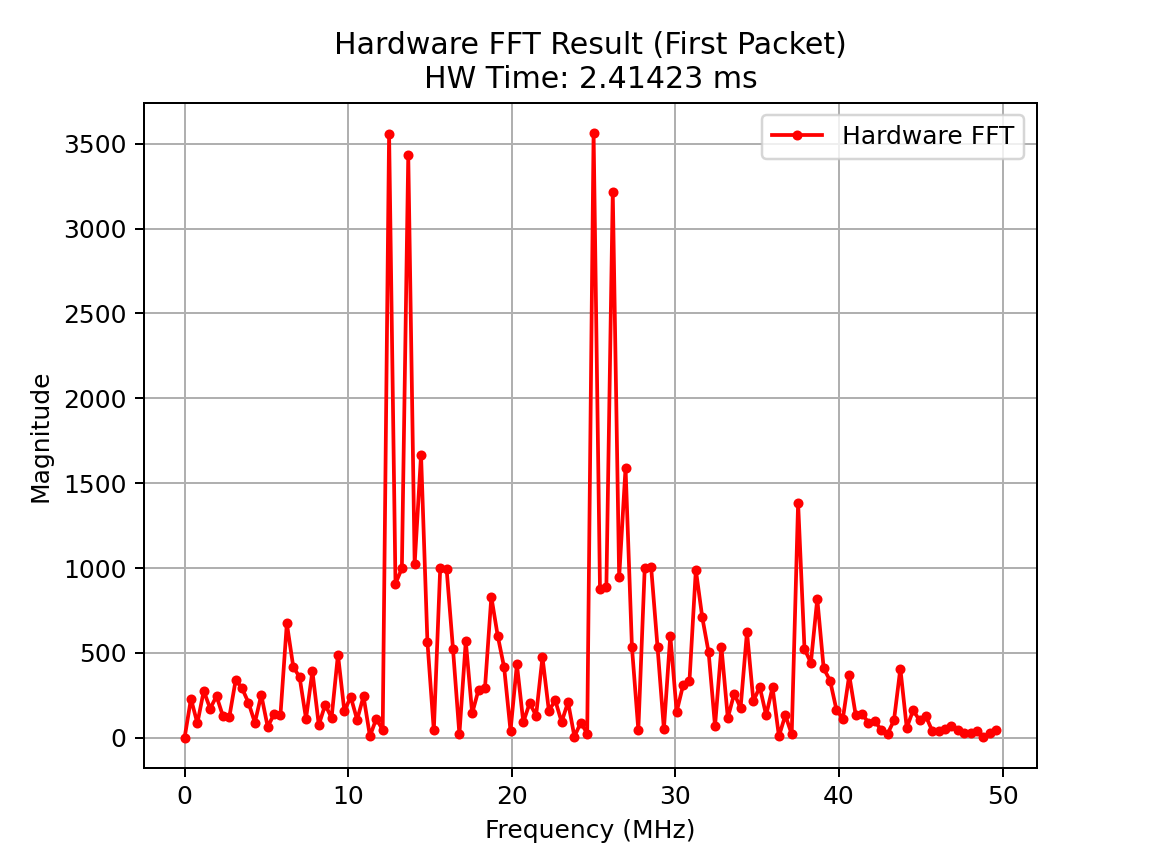

In [20]:
# ------------------------------------------------------------------
# 5. Visualization (Verify Result)
# ------------------------------------------------------------------
# 주파수 축 계산 (100MHz, 256 point)
freqs = np.fft.fftfreq(fft_size, d=1/fs)
mask = freqs >= 0
freqs_pos = freqs[mask] / 1e6

# 첫 번째 패킷(256 샘플)의 결과만 추출하여 플롯
magnitude_hw = np.abs(out_buffer[mask])

plt.figure()
plt.plot(freqs_pos, magnitude_hw, 'r.-', label='Hardware FFT')
plt.title(f"Hardware FFT Result (First Packet)\nHW Time: {hw_exec_time*1e3:.5f} ms")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
print(len(out_buffer))
print(out_buffer)

256
[-1.31225586e-02+0.00000000e+00j -2.20067932e+02-6.36406746e+01j
 -8.39255981e+01+1.45989676e+01j  1.24708183e+02-2.46526764e+02j
 -1.64665863e+02+4.81663513e+01j  1.17465195e+02-2.15106171e+02j
  1.14159729e+02-5.72443161e+01j  1.15934326e+02+3.80037766e+01j
 -3.04525604e+02+1.54239075e+02j  1.41438599e+02-2.54165985e+02j
  1.66375031e+02-1.21611641e+02j  8.80403214e+01+1.16294889e+01j
  1.76020264e+02-1.80873535e+02j  1.44160843e+01+6.28734131e+01j
 -7.80031967e+01+1.14335175e+02j -4.50108528e-01+1.33266235e+02j
 -4.97273376e+02+4.54440857e+02j  1.73917389e+02-3.81334595e+02j
  2.26353424e+02-2.74866089e+02j  1.07215034e+02-3.40187492e+01j
  2.02524612e+02-3.35366974e+02j  2.58851757e+01+7.06357346e+01j
 -7.29589233e+01+1.79558411e+02j  2.16420250e+01+1.15542099e+02j
  1.28422058e+02-4.72436096e+02j  2.71659470e+01+1.55261688e+02j
 -2.66095257e+01+2.38982056e+02j  1.42947664e+01+1.04966805e+02j
  1.31506443e+01+2.44404755e+02j -5.91820002e-01+9.73464489e+00j
 -2.60089474e+01-1.08

In [22]:
print(len(in_buffer))
print(in_buffer)

256
[ 0.00000000e+00+0.j  1.29547222e-02+0.j  3.03501952e-02+0.j
 -1.99960154e-02+0.j -1.48582830e-17+0.j  5.54995313e-02+0.j
 -2.72709787e-01+0.j -6.33241296e-01+0.j -3.55733483e-16+0.j
  1.04509211e+00+0.j  7.55076587e-01+0.j -2.67315269e-01+0.j
 -2.32573288e-15+0.j  3.72450739e-01+0.j -1.47276866e+00+0.j
 -2.88192797e+00+0.j -2.81831261e-15+0.j  3.68967843e+00+0.j
  2.41881990e+00+0.j -7.87878513e-01+0.j -7.10559592e-15+0.j
  9.58573997e-01+0.j -3.58404803e+00+0.j -6.67192173e+00+0.j
 -5.46064692e-14+0.j  7.84428740e+00+0.j  4.95714283e+00+0.j
 -1.56152403e+00+0.j -4.90138622e-15+0.j  1.79116845e+00+0.j
 -6.52477694e+00+0.j -1.18564348e+01+0.j -2.16817192e-14+0.j
  1.33480091e+01+0.j  8.27173519e+00+0.j -2.55828834e+00+0.j
 -4.28586711e-14+0.j  2.83798742e+00+0.j -1.01810598e+01+0.j
 -1.82346687e+01+0.j -1.60388548e-13+0.j  1.99876823e+01+0.j
  1.22342205e+01+0.j -3.73956609e+00+0.j -6.52096175e-14+0.j
  4.05848694e+00+0.j -1.44112873e+01+0.j -2.55595913e+01+0.j
 -3.99759544e-13+0.j

In [23]:
fft_top.register_map

RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=1, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0)
}

In [24]:
del in_buffer, out_buffer